In [1]:
import torch
import torchvision

### 1. Chuẩn bị và khảo sát dữ liệu
- Dữ liệu hình ảnh Fashion MNIST (https://github.com/zalandoresearch/fashion-mnist)
- Làm quen thư viện torchvision: Dataset, DataLoader

In [9]:
import os
import gzip
import numpy as np

In [27]:
import matplotlib.pyplot as plt

In [10]:
root_dir = 'data/fashion_mnist'

In [21]:
def read_mnist(images_path, labels_path):
    with gzip.open(labels_path, 'rb') as lbpath:
        labels = np.frombuffer(lbpath.read(), 
                               dtype=np.uint8,
                               offset=8)

    with gzip.open(images_path, 'rb') as imgpath:
        images = np.frombuffer(imgpath.read(),
                               dtype=np.uint8,offset=16).reshape(len(labels), 784)
        
    return images, labels

In [22]:
X_train, y_train = read_mnist(os.path.join(root_dir, 'train-images-idx3-ubyte.gz'),
                             os.path.join(root_dir, 'train-labels-idx1-ubyte.gz'))

X_test, y_test = read_mnist(os.path.join(root_dir, 't10k-images-idx3-ubyte.gz'),
                             os.path.join(root_dir, 't10k-labels-idx1-ubyte.gz'))

In [23]:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

In [25]:
print(X_train.shape)
print(y_train.shape)

(60000, 784)
(60000,)


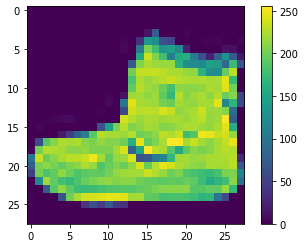

In [30]:
plt.figure()
plt.imshow(X_train[0].reshape(28, 28))
plt.colorbar()
plt.show()

In [33]:
# Chuẩn hóa dữ liệu hình ảnh --> đưa về khoản 0,1
X_train = X_train/255.0
X_test = X_test/255.0

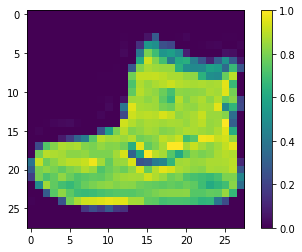

In [34]:
plt.figure()
plt.imshow(X_train[0].reshape(28, 28))
plt.colorbar()
plt.show()

In [59]:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

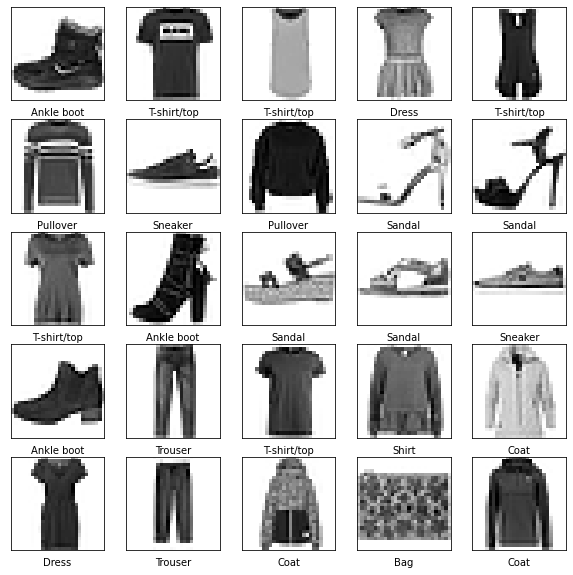

In [61]:
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(X_train[i].reshape(28,28), cmap=plt.cm.binary)
    plt.xlabel(class_names[y_train[i]])
plt.show()

#### Chia train/valid

In [90]:
np.random.seed(100)
shuffle_indices_train = np.arange(0, len(y_train))
np.random.shuffle(shuffle_indices_train)

In [92]:
X_valid = X_train[shuffle_indices_train[:10000]]
y_valid = y_train[shuffle_indices_train[:10000]]
X_train = X_train[shuffle_indices_train[10000:]]
y_train = y_train[shuffle_indices_train[10000:]]

print('Train size:', X_train.shape)
print('Valid size:', X_valid.shape)

Train size: (50000, 784)
Valid size: (10000, 784)


#### Tạo Dataset, Dataloader

In [38]:
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms

In [127]:
class FashionDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.transform = transform
        self.labels = np.asarray(labels)
        # Dimension of Images = 28 * 28 * 1. height = width = 28 and color_channels = 1.
        self.images = np.asarray(images).reshape(-1, 28, 28, 1).astype('float32')
#         self.images = np.asarray(images).reshape(-1, 784, 1).astype('float32')

    def __getitem__(self, index):
        label = self.labels[index]
        image = self.images[index]
        
        if self.transform is not None:
            image = self.transform(image)

        return image, label

    def __len__(self):
        return len(self.images)

In [128]:
# Tạo dataset và dataloader
train_set = FashionDataset(X_train, y_train)
valid_set = FashionDataset(X_valid, y_valid)
test_set = FashionDataset(X_test, y_test)

train_loader = DataLoader(train_set, batch_size=100)
valid_loader = DataLoader(valid_set, batch_size=100)
test_loader = DataLoader(test_set, batch_size=100)

In [129]:
# Kiểm tra phần tử đầu tiên của dataloader
a = next(iter(train_loader))
a[0].size()

torch.Size([100, 28, 28, 1])

In [95]:
# In ra kích cỡ của train_set, test_set
len(train_set)

50000

1


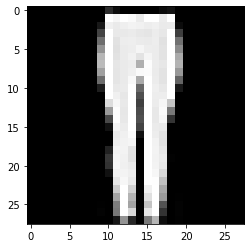

In [96]:
image, label = next(iter(train_set))
plt.imshow(image.squeeze(), cmap="gray")
print(label)

### 2. Tạo mô hình

In [69]:
import torch.nn as nn
import torch

In [97]:
class Classifier(nn.Module):
    def __init__(self):
        super(Classifier, self).__init__()
        self.flatten_layer = nn.Flatten()
        self.layer1 = nn.Linear(in_features=784, out_features=128)
        self.relu = nn.ReLU()
        self.layer2 = nn.Linear(in_features=128, out_features=10)
        
    def forward(self, x):
        x = self.flatten_layer(x)
        x = self.layer1(x)
        x = self.relu(x)
        x = self.layer2(x)
        
        return x

### 3. Huấn luyện mô hình

#### Định nghĩa các thành phần cần thiết

In [73]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [79]:
model = Classifier()
model = model.to(device)
loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [80]:
print(model)

Classifier(
  (flatten_layer): Flatten(start_dim=1, end_dim=-1)
  (layer1): Linear(in_features=784, out_features=128, bias=True)
  (relu): ReLU()
  (layer2): Linear(in_features=128, out_features=10, bias=True)
)


#### Viết training loop

In [98]:
num_epochs = 5
count = 0

# các metric cần quan sát
loss_list = []
iteration_list = []
accuracy_list = []

# Lists for knowing classwise accuracy
predictions_list = []
labels_list = []

# với mỗi epoch,
for epoch in range(num_epochs):
    # lặp qua dataloader
    for images, labels in train_loader:
        # Transfer images and labels tới device (GPU, CPU)
        images, labels = images.to(device), labels.to(device)
        
#         train = Variable(images.view(100, 1, 28, 28))
#         labels = Variable(labels)
        
        # Forward pass 
        outputs = model(images)
        loss = loss_func(outputs, labels)
        
        # Initializing a gradient as 0 so there is no mixing of gradient among the batches
        # Zero gradients, tránh việc nhầm lẫn với gradient của đợt train trước
        optimizer.zero_grad()
        
        # Backward để tính gradient
        loss.backward()
        
        # Tối ưu hóa các tham số bằng bộ optimizer
        # Cần gọi loss.backward() để tính gradient trước bước này
        optimizer.step()
    
        count += 1
    
        # Testing
        if not (count % 50):
            total = 0
            correct = 0
        
            for images, labels in valid_loader:
                images, labels = images.to(device), labels.to(device)
                labels_list.append(labels)
            
#                 test = Variable(images.view(100, 1, 28, 28))
            
                outputs = model(images)
            
                predictions = torch.max(outputs, 1)[1].to(device)
                predictions_list.append(predictions)
                correct += (predictions == labels).sum()
            
                total += len(labels)
            
            accuracy = correct * 100 / total
            loss_list.append(loss.data)
            iteration_list.append(count)
            accuracy_list.append(accuracy)
        
        if not (count % 500):
            print("Iteration: {}, Loss: {}, Accuracy: {}%".format(count, loss.data, accuracy))

Iteration: 500, Loss: 0.29911381006240845, Accuracy: 88.75%
Iteration: 1000, Loss: 0.2785705626010895, Accuracy: 88.73999786376953%
Iteration: 1500, Loss: 0.27347901463508606, Accuracy: 88.70999908447266%
Iteration: 2000, Loss: 0.2645626664161682, Accuracy: 88.66999816894531%
Iteration: 2500, Loss: 0.25985798239707947, Accuracy: 88.83000183105469%


### 4. Kiểm thử mô hình

In [117]:
probability_model = nn.Sequential(model.eval(), nn.Softmax(dim=-1))

In [118]:
def predict(classifier, image):
    image = np.expand_dims(image, axis=0)
    image = torch.Tensor(image)
    pred = probability_model(image).cpu().detach().numpy()
    
    return np.argmax(pred), pred

In [119]:
pred_class, raw_pred = predict(probability_model, image)
print('Pred class:', pred_class)
print('Raw pred:', raw_pred)

Pred class: 9
Raw pred: [[2.6788039e-06 4.0375927e-08 1.3003587e-07 4.3740488e-07 1.2622887e-07
  6.0536498e-03 6.8259483e-06 1.2945953e-02 4.4015454e-05 9.8094624e-01]]


In [108]:
image, label = test_set[0]
image = np.expand_dims(image, axis=0)
print(image.shape)
image = torch.Tensor(image)
pred = probability_model(image)
pred

(1, 28, 28, 1)


tensor([[2.6788e-06, 4.0376e-08, 1.3004e-07, 4.3740e-07, 1.2623e-07, 6.0536e-03,
         6.8259e-06, 1.2946e-02, 4.4015e-05, 9.8095e-01]],
       grad_fn=<SoftmaxBackward0>)

In [138]:
def plot_image(i, predictions_array, true_label, img):
    true_label, img = true_label[i], img[i]
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])

    plt.imshow(img.reshape(28,28), cmap=plt.cm.binary)

    predicted_label = np.argmax(predictions_array)
    if predicted_label == true_label:
        color = 'blue'
    else:
        color = 'red'

    plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                100*np.max(predictions_array),
                                class_names[true_label]),
                                color=color)

def plot_value_array(i, predictions_array, true_label):
    true_label = true_label[i]
    plt.grid(False)
    plt.xticks(range(10))
    plt.yticks([])
    thisplot = plt.bar(range(10), predictions_array, color="#777777")
    plt.ylim([0, 1])
    predicted_label = np.argmax(predictions_array)

    thisplot[predicted_label].set_color('red')
    thisplot[true_label].set_color('blue')

In [139]:
all_test_preds = []
all_labels = []
# torch.Tensor
for batch in test_loader:
    images, labels = batch
    preds = probability_model(images)
    all_test_preds.extend(preds.cpu().detach().numpy())

In [140]:
all_test_preds[0]

array([2.6788039e-06, 4.0375927e-08, 1.3003537e-07, 4.3740616e-07,
       1.2622911e-07, 6.0536531e-03, 6.8259610e-06, 1.2945958e-02,
       4.4015287e-05, 9.8094624e-01], dtype=float32)

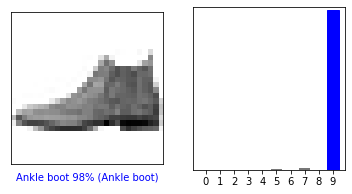

In [143]:
i = 0
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(i, all_test_preds[i], y_test, X_test)
plt.subplot(1,2,2)
plot_value_array(i, all_test_preds[i],  y_test)
plt.show()

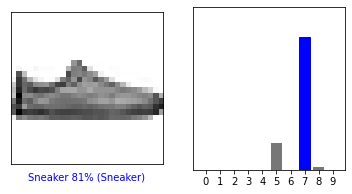

In [142]:
i = 12
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(i, all_test_preds[i], y_test, X_test)
plt.subplot(1,2,2)
plot_value_array(i, all_test_preds[i],  y_test)
plt.show()

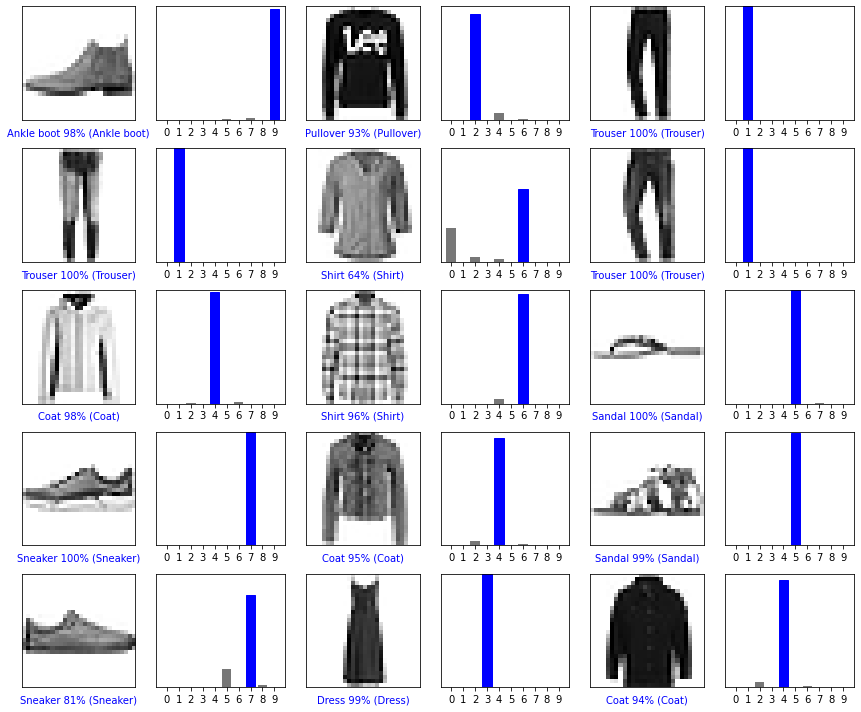

In [146]:
num_rows = 5
num_cols = 3
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
    plt.subplot(num_rows, 2*num_cols, 2*i+1)
    plot_image(i, all_test_preds[i], y_test, X_test)
    plt.subplot(num_rows, 2*num_cols, 2*i+2)
    plot_value_array(i, all_test_preds[i], y_test)
plt.tight_layout()
plt.show()